# 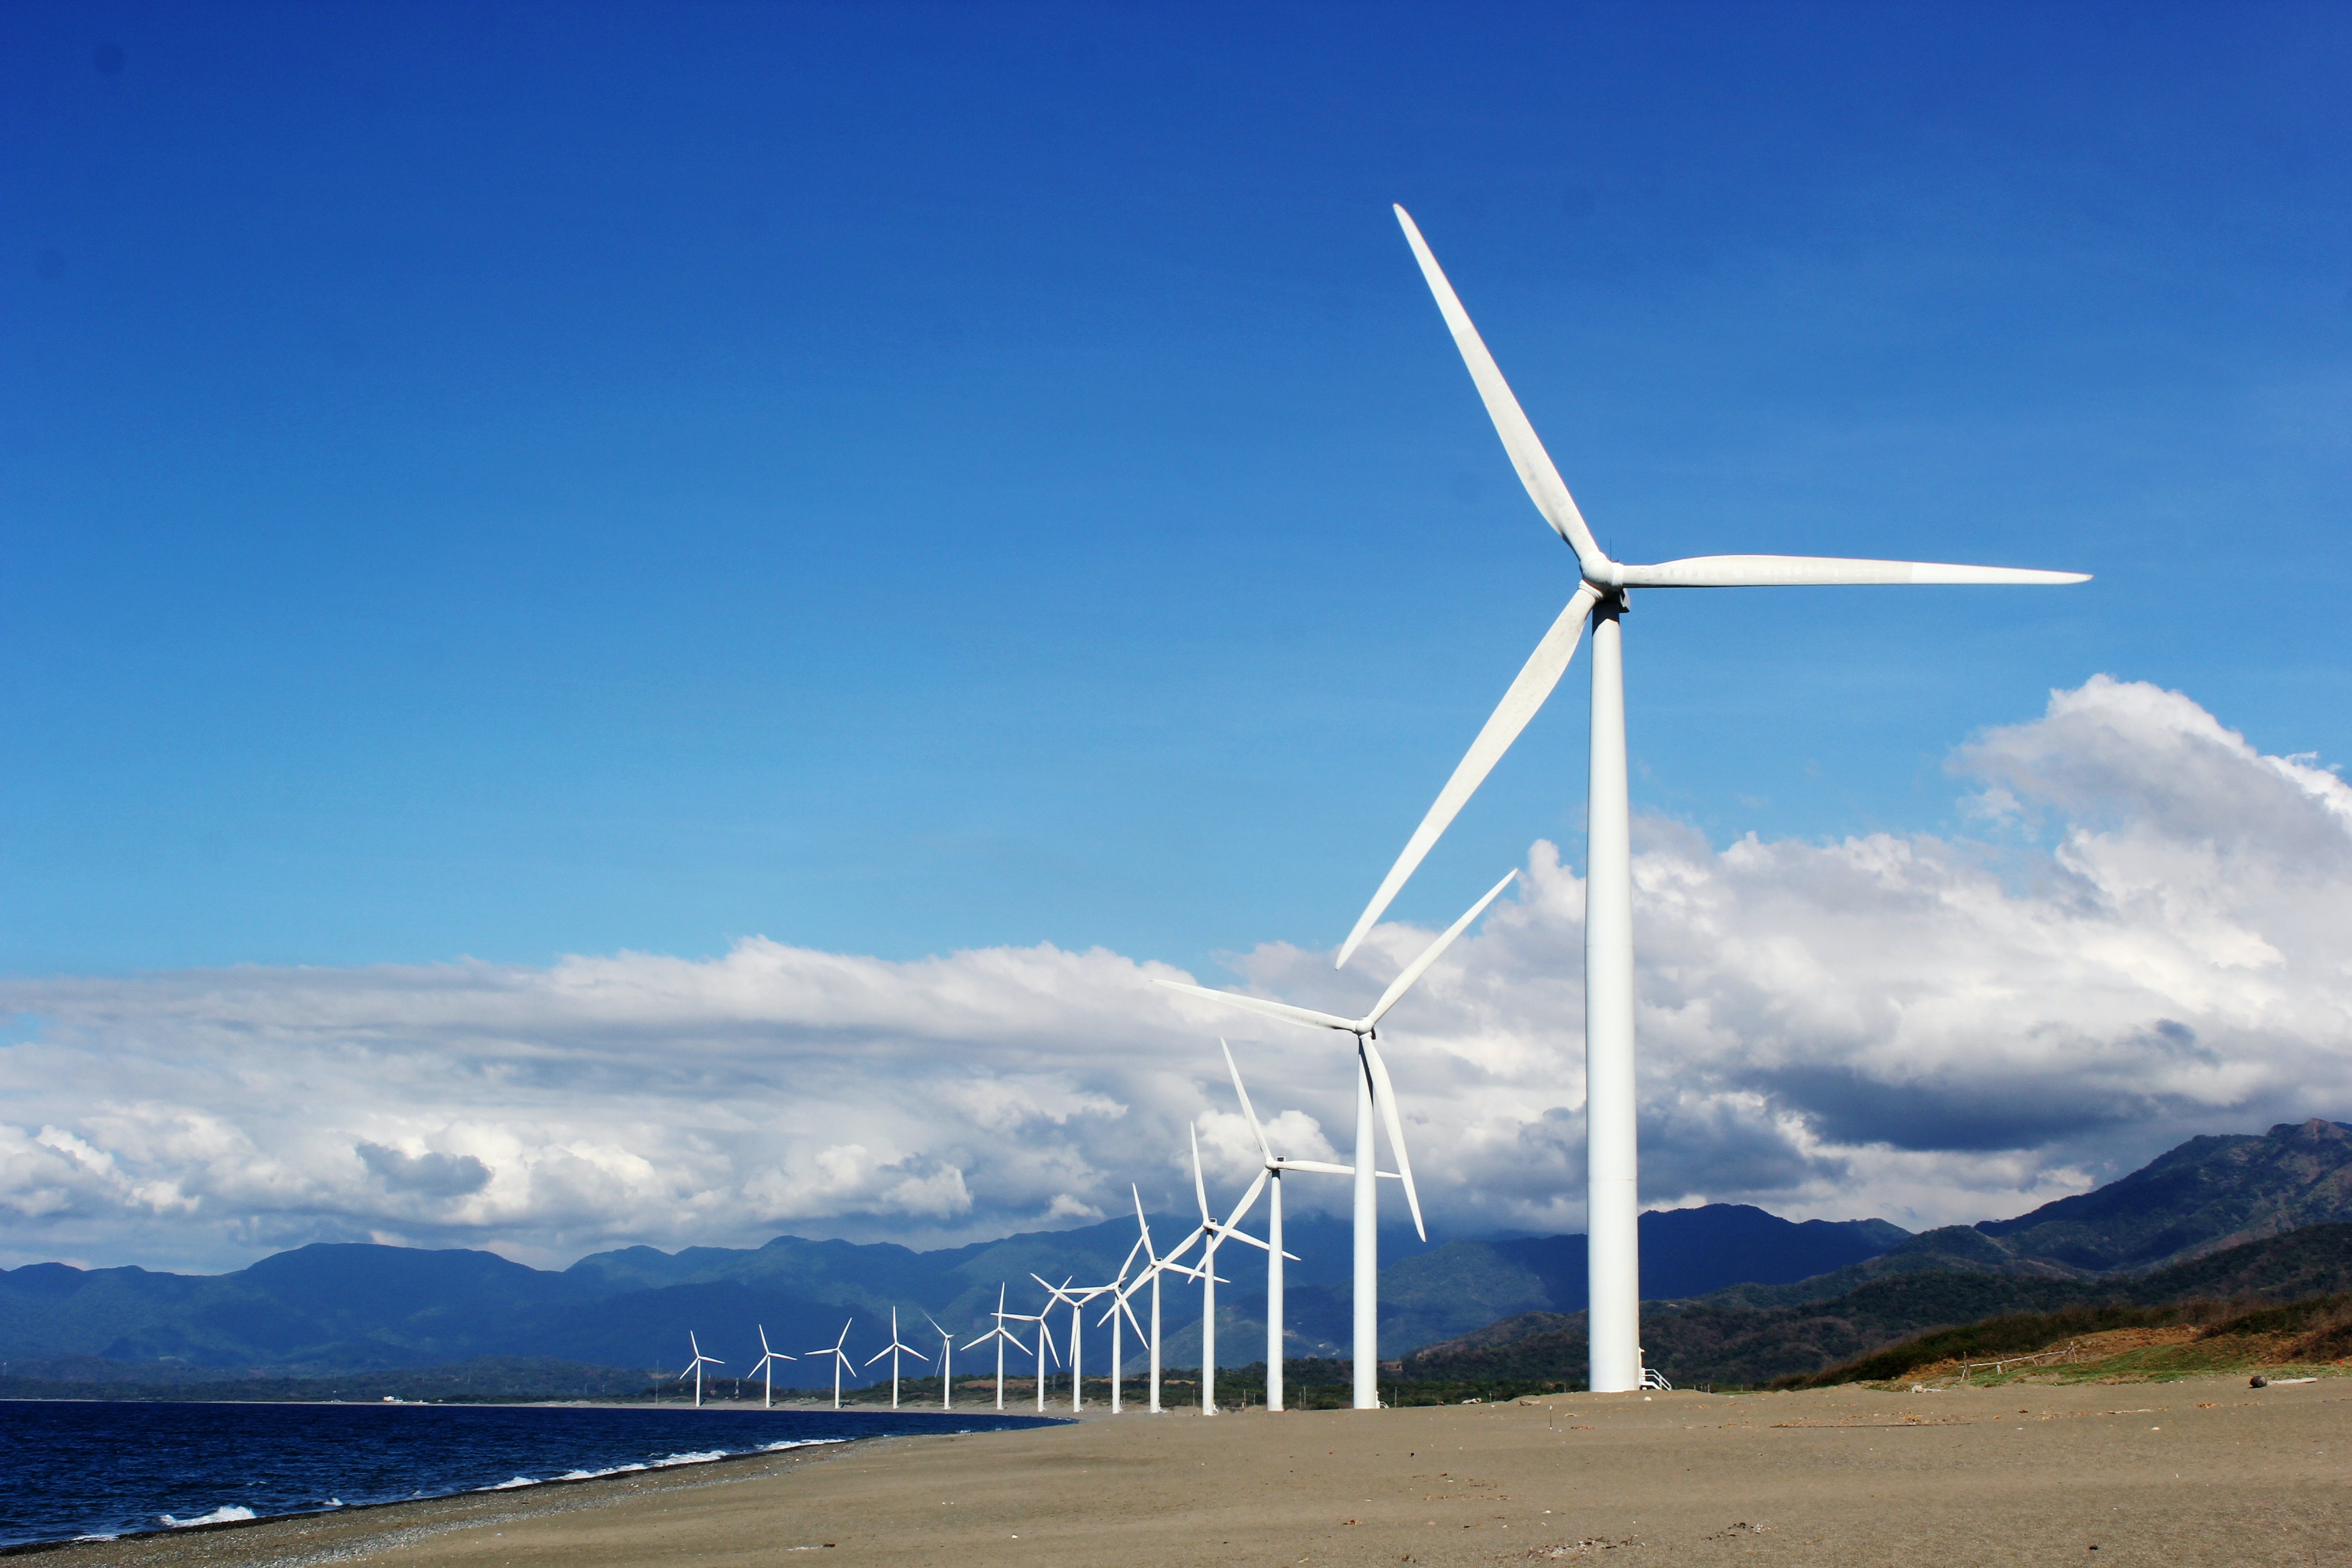

## This project, which utilizes data analytics in wind turbines, aims to optimize performance, predict maintenance needs, and improve the overall efficiency of power generation. Wind power curves play important roles in wind power forecasting, wind turbine condition monitoring, estimation of wind energy potential and wind turbine selection. 

## On track with the performance of individual turbines within a wind farm, this helps to identify if any turbines is underperforming or experiencing issues that require attention. The objective is to leverage data analytics in wind energy to allow a more reliable and cost-effective operation, contributing to a more sustainable and efficient use of renewable resources. 




<!-- <p style="font-size:22px;font-weight:bold"> Table of Contents</p> -->


# Table of Contents:

### 1. [Importing Library](#import_library)
* Importing all Python libraries required for this project.


### 2. [Load Data](#load_data)
* Access data from the CSV then retrieve the data in the form of dataframe, wind speed, wind direction, generated power with 10 minutes intervals. 
* Please download the data from Kaggle before running the code below.
* Goto https://www.kaggle.com/datasets/berkerisen/wind-turbine-scada-dataset and download the T1.csv dataset. Rename T1.csv to scada.csv and place it in the same directory as this notebook.

##### The wind turbine data set contains:

* Date/Time (for 10 minutes intervals)
* LV ActivePower (kW): The power generated by the turbine for that moment
* Wind Speed (m/s): The wind speed at the hub height of the turbine (the wind speed that turbine uses for electricity generation)
* Theoretical_Power_Curve (kWh): The theoretical power values that the turbine generates with that wind speed which is given by the turbine manufacturer
* Wind Direction (°): The wind direction at the hub height of the turbine (wind turbines turn to this direction automatically)

### 3. [Exploring Data](#exploring_data)
* Check Null Data 
* Convert to datetime format 
* Get Hourly average active power generated by the wind-turbine on data analytics
* Get Monthly average active power generated by the wind-turbine on data analytics
* Exploring data on Active Power generated by the wind-turbine vs Theoretical Power for data visualization 

### 4. [Data Preprocessing and Data Analysis](#data_analytics)
* Perform data analysis on the active power curves of all wind directions to objectively analyze which wind direction produces the best power performance 

### 5. [Prediction Anomaly Model Based on Standard Scikit Learn](#prediction_model)
* The Wind Turbines Prediction Anomalies Model is uses based on ML designed to forecast and detect irregularities in wind turbine performance. It leverages historical data Active Power and Wind Speed to make accurate predictions about expected power output 
* The objective is to enable timely maintenance interventions, minimizing downtime and optimizing overall energy generation efficiency

### 6. [Prediction Anomaly Model Based on Intel® Extension for Scikit-learn](#intel_ext_sc_learn)
* Intel® AI Analytics Toolkit (AI Kit) provides flexibility to use machine learning tools with existing AI packages
* Intel® Extension for Scikit-learn dynamically patches scikit-learn estimators while improving performance for machine learning algorithms
    




# 1. Importing Library <a class="anchor" id="import_library"></a>

#### Import the necessary libraries to explore and analyze dataframes


In [ ]:

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import time
from windrose import WindroseAxes

turbine_no="T1" #for powercurve graph

import warnings
warnings.filterwarnings("ignore")



# 2. Load Data <a class="anchor" id="load_data"></a>

#### Read the CSV file and load the dataframe 


In [ ]:

df = pd.read_csv('scada.csv')
df.head()



#### Renaming the label for easier recall of dataframe names


In [ ]:

df.columns = ['date', 'active_power', 'wind_speed', 'theor_power', 'wind_dir']
df



# 3. Exploring Data <a class="anchor" id="exploring_data"></a>

#### Before building the ML model, it is recommended to explore the data, to get a better understanding of its structure and identify any potential issues



## 3.1 Check Null Data 

#### Explore the data required to check if a dataframe contains null values


In [ ]:

df.isna().sum()



## 3.2 Convert to datetime Format

#### To convert date into datetime format for data exploring


In [ ]:

df['date'] = pd.to_datetime(df['date'],dayfirst=True)

df.set_index('date', inplace=True)
df


## 3.3 Add Hourly into Dataframe for Data Exploring

####  Add hours to a dataframe to explore hourly power generation performance analytics


In [ ]:

dates = df.index
hours = [date.hour for date in dates]
df['hour'] = hours
df



#### Group the dataframe by hours (hour 0 to 24) then explore the average of active power

In [ ]:

df.groupby('hour').mean().active_power.plot(kind='bar', title='Average of Active Power of each Hours')



## 3.4 Add Monthly into Dataframe for Data Exploring

####  Add months to a dataframe for exploring monthly power generation performance analytics



In [ ]:

dates = df.index
months = [date.month for date in dates]
df['month'] = months
df



#### To identify which month having the higher active power generation [kW] and plot

In [ ]:

color = list(np.full(12, 'grey'))
color[2], color[7] = 'orange', 'orange'

df.groupby('month').mean().active_power.plot(kind='bar', title='Average of Active Power of each Months', color=color, rot=0)
plt.ylabel('Active Power [kW]')



#### Resample weekly average power and plots to explore weekly generation performance analysis

In [ ]:

df.resample('W').mean().active_power.plot(figsize=(12,3))



## 3.5 Exploring Data on Theoretical Power vs Active Power  

#### Filter the Real Active Power and Theoretical Power dataset and added the anomaly_status column into Active Power for later analytics anomaly 


In [ ]:

df_activepwr = df.filter(['wind_speed','active_power'])
df_theorpwr = df.filter(['date','wind_speed','theor_power'])
df_activepwr.insert(len(df_activepwr.columns), "anomaly_status", 0)
df_activepwr



#### Plot the Theoretical Power Curve

In [ ]:

df_theorpwr.plot(kind='scatter',x='wind_speed',y='theor_power')



#### Plot the Real Active Power Curve

In [ ]:

df_activepwr.plot(kind='scatter',x='wind_speed',y='active_power')



#### Plot the Theoretical Power Curve vs Real Active Power Curve for visualization 

In [ ]:

ax = df.plot(x='wind_speed', y='active_power', style='o')
df.plot(x='wind_speed', y='theor_power', style='.', ax=ax)



#### Calculate power loss Theoretical Power - Real Active Power

In [ ]:

df['loss'] = df['theor_power'] - df['active_power']
df



#### Resample weekly average Power Loss and plot

In [ ]:

df.resample('D').mean().loss.plot(figsize=(12,3))




# 4. Data Preprocessing and Data Analysis <a class="anchor" id="data_analytics"></a>

#### Data analysis on the Active Power Curve for all the Wind Direction and plot for visualization



## 4.1 Define the Data Preprocessing Function for Wind Speed of 0.5 intervals
#### For this use case: Wind speeds between 3.25 and 3.75 turns 3.5, wind speeds between 3.75 and 4.25 turns 4.0


In [ ]:

def mean_speed(x):
    list=[]
    i=0.25
    while i<=25.5:
        list.append(i)
        i+=0.5
        
    for i in list:
        if x < i:
            x=i-0.25
            return x
        


#### To add a new column as "mean_WindSpeed" with function mean_speed()


In [ ]:

df["mean_WindSpeed"]=df["wind_speed"].apply(mean_speed)
df



## 4.2 Define the Data Preprocessing Function of the Wind Direction
#### For this usecase: Wind directions between 15 and 45 turns 30, wind speeds between 45 and 75 turns 60


In [ ]:

def mean_direction(x):
    list=[]
    i=15
    while i<=375:
        list.append(i)
        i+=30
        
    for i in list:
        if x < i:
            x=i-15
            if x==360:
                return 0
            else:
                return x
            

#### To add a new column as "mean_Direction" with function mean_direction()

In [ ]:

df["mean_Direction"]=df["wind_dir"].apply(mean_direction)
df.head (200)



## 4.3 Define Function of the Wind Direction with Right Direction Letters 
#### For this usecase: 0=N, 30=NNE 60=NEE etc.


In [ ]:

def find_direction(x):
    if x==0:
        return "N"
    if x==30:
        return "NNE"
    if x==60:
        return "NEE" 
    if x==90:
        return "E" 
    if x==120:
        return "SEE" 
    if x==150:
        return "SSE" 
    if x==180:
        return "S" 
    if x==210:
        return "SSW" 
    if x==240:
        return "SWW" 
    if x==270:
        return "W" 
    if x==300:
        return "NWW" 
    if x==330:
        return "NNW"
  

#### To add a new column as "Direction" with function find_direction()

In [ ]:

df["Direction"]=df["mean_Direction"].apply(find_direction)
df.head (10)



## 4.4 Data Preprocessing 
#### Preprocessing data frames on Wind-Direction for data analysis.



#### Number of values where wind speed is bigger than 3 and less than 25 and active power is zero. 
#### If wind speed is bigger than 3 and active power is zero, this means turbine is out of order. We must eliminate these.


In [ ]:

data2_clean=df[(df["wind_speed"]>3) & (df["wind_speed"]<=25)]

len(data2_clean["active_power"][(data2_clean["active_power"]==0)&(data2_clean["wind_speed"]>3)])



#### Eliminate datas where wind speed is bigger than 3 and active power is not zero.
#### Then check length of values of Wind Speed


In [ ]:

data2_clean=data2_clean[((data2_clean["active_power"]!=0)&(data2_clean["wind_speed"]>3)) | (data2_clean["wind_speed"]<=3.5)]

len(data2_clean["wind_speed"])



#### To lock in the clean data before peforming Wind Direction data analytics


In [ ]:

data_F_clean=data2_clean.sort_values("date")
data_F_clean["loss"]=data_F_clean["theor_power"]-data_F_clean["active_power"]

data_F_clean=data_F_clean.round({'active_power': 2, 'wind_speed': 2, 'theor_power': 2,
                                  'wind_dir': 2, 'loss': 2})

data_F_clean.head()


#### Checking for maximum and minimum value of the Wind Direction to help in choosing the right binning value

In [ ]:

print(data_F_clean['wind_dir'].max())
print(data_F_clean['wind_dir'].min())



## 4.5 Finally Label All Wind Directions from Clean Data
#### Create summary dataframes for all directions from clean data in for loop as we did previously when creating direction dataframe


In [ ]:

list_data=[]
list_yon=["N","NNE","NEE","E","SEE","SSE","S","SSW","SWW","W","NWW","NNW"]

for i in range(0,12):
    data1T_A=data_F_clean[data_F_clean["Direction"]==list_yon[i]]
    #
    DepGroup_A = data1T_A.groupby("mean_WindSpeed")
    #data_T_A=DepGroup_A.mean()
    data_T_A=DepGroup_A.mean(numeric_only=True)
    #
    data_T_A.drop(columns={"wind_speed","wind_dir","mean_Direction"},inplace=True)
    #
    listTA_WS=data_T_A.index.copy()
    data_T_A["wind_speed"]=listTA_WS
    #
    data_T_A=data_T_A[["wind_speed","active_power","theor_power","loss"]]
    #
    data_T_A=data_T_A.round({'active_power': 2, 'theor_power': 2, 'loss': 2})
    #
    data_T_A["count"]=[len(data1T_A["mean_WindSpeed"][data1T_A["mean_WindSpeed"]==x]) 
                            for x in data_T_A["wind_speed"]]
    list_data.append(data_T_A)
    
data_T_N=list_data[0]
data_T_NNE=list_data[1]
data_T_NEE=list_data[2]
data_T_E=list_data[3]
data_T_SEE=list_data[4]
data_T_SSE=list_data[5]
data_T_S=list_data[6]
data_T_SSW=list_data[7]
data_T_SWW=list_data[8]
data_T_W=list_data[9]
data_T_NWW=list_data[10]
data_T_NNW=list_data[11]


## 4.6 Visualization of Data Analytics

#### Plot the power curve of the turbine for all directions for analytics, drawing power curve of the turbine for all directions.
#### N"=0,"NNE"=1,"NEE"=2,"E"=3,"SEE"=4,"SSE"=5,"S"=6,"SSW"=7,"SWW"=8,"W"=9,"NWW"=10,"NNW"=11

In [ ]:

list_table=[data_T_N,data_T_NNE,data_T_NEE,data_T_E,data_T_SEE,data_T_SSE,data_T_S,
            data_T_SSW,data_T_SWW,data_T_W,data_T_NWW,data_T_NNW]

list_tableName=["N","NNE","NEE","E","SEE","SSE","S","SSW","SWW","W","NWW","NNW"]

def graph_T(i):
    fig = plt.figure(figsize=(20,10))  
    plt.plot(list_table[i]["wind_speed"].values,list_table[i]["theor_power"].values,label="Theoretical Power Curve",
             marker="o",markersize=10,linewidth = 5)
    plt.plot(list_table[i]["wind_speed"].values,list_table[i]["active_power"].values,label="Actual Power Curve",
             marker="o",markersize=10,linewidth = 5)
    plt.xlabel("Wind Speed (m/s)")
    plt.ylabel("Power (kW)")
    plt.title("Wind Farm {} Power Curve According to {} Wind".format(turbine_no,list_tableName[i]))
    plt.legend()
    plt.show()
    fig.savefig("{}_{}_Powercurve.jpeg".format(turbine_no,list_tableName[i]))
    plt.close(fig)

for i in range(0,12):
    graph_T(i)
    

 
## 4.7 Create Wind Axes Visualization
#### Create Wind Speed and Wind Direction variables and plot the wind axes


In [ ]:

ax = WindroseAxes.from_ax()
ax.bar(data_F_clean['mean_Direction'], data_F_clean['wind_speed'], normed=True, opening=0.8, edgecolor='white')
ax.set_legend()





# 5. Create a Wind Turbines Prediction Anomaly Model <a class="anchor" id="prediction_model"></a>

#### The Wind Turbines Prediction Anomalies Model is a machine learning designed to forecast and detect irregularities in wind turbine performance. It leverages historical data (Active Power & Wind Speed) to make accurate predictions about expected power output. 
#### The model can identify anomalies such as unexpected drops in energy production or unusual fluctuations in wind speed. Mainly enables timely maintenance interventions, minimizing downtime and optimizing overall energy generation efficiency.


## 5.1 Import the Standard scikit-learn library 
#### Import the necessary scikit-learn libraries to train and perform prediction data


In [ ]:

from sklearn import metrics
from sklearn import model_selection
from sklearn import preprocessing
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
import pickle
from collections import deque
import math


## 5.2 Visualization Data on Theoretical Power vs Active Power Curve 

#### Plot the theoretical power curve versus the actual active power curve for visualization before creating the prediction model

In [ ]:

df = df
exp = df['active_power']
the = df['theor_power']
plt.figure(figsize=(25,10)) 
plt.plot(df['wind_speed'].values, df['active_power'].values, 'o', label='Real Power')
plt.plot(df['wind_speed'].values, df['theor_power'].values, '.', label='theoretical_power_curve (kwh)')
plt.xlabel('wind speed (m/s)', size=15)
plt.ylabel('Power Production (kw)', size=15)
plt.title('Wind Turbine Power Production Prediction')
plt.legend(fontsize=15)
plt.show()



## 5.3 Data Preprocessing and Visualization

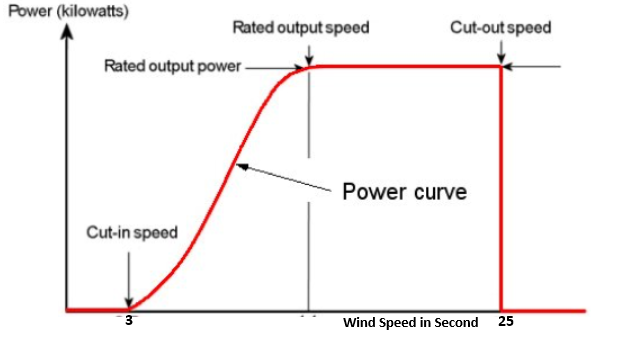

#### A typical wind power curve is shown above. Each wind turbine manufacturer provides an ideal energy production curve for the turbines.

#### It needs the preprocessing data for Active Power to clean outliers on dataset.


In [ ]:

cut_in_speed = 3
cut_out_speed = 25
min_power_th = 50
# cleaning as per point 1 and 2
df_process = df_activepwr[((df_activepwr["active_power"]>min_power_th) & (df_activepwr["wind_speed"]>cut_in_speed) & (df_activepwr["wind_speed"]<cut_out_speed)) | (df_activepwr["wind_speed"]<=cut_in_speed)]

# remove point anomalies using IQR
# Create Sub-DataFrames
d = {}
step = 50
i = 0
for x in range(3, 3700, step):
    d[i] = df_process.iloc[((df_process['active_power']>=x)&((df_process['active_power']<x+step))).values]
    i = i + 1
print("There are in total of {} DataFrames".format(i+1))
d[i] = df_process.iloc[(df_process['active_power']>=3500).values]

def outlier_remover(dat, prop, min, max):
    d = dat
    q_low = d[prop].quantile(min)
    q_hi  = d[prop].quantile(max)
    return d[(d[prop] < q_hi) & (d[prop] > q_low)]


for x in range(i):
    F = 0.8
    d[x] = outlier_remover(d[x], 'wind_speed', 0.0001, F)
    
df_clean=pd.DataFrame()

for infile in range(i):
    data = d[infile]
    df_clean=df_clean._append(data,ignore_index=True)  
    


####  Visualization of the clean data before model training and prediction

In [ ]:

df_clean.plot(kind='scatter',x='wind_speed',y='active_power')



#### Visualization on the Theoretical Power Curve vs Clean Active Power Curve and before training the model

In [ ]:

exp = df_clean['active_power']
the = df['theor_power']
plt.figure(figsize=(25,10)) 
plt.plot(df_clean['wind_speed'].values, df_clean['active_power'].values, 'o', label='Real Power')
plt.plot(df['wind_speed'].values, df['theor_power'].values, '.', label='theoretical_power_curve (kwh)')
plt.xlabel('wind speed (m/s)', size=15)
plt.ylabel('Power Production (kw)', size=15)
plt.title('Wind Turbine Power Production Prediction')
plt.legend(fontsize=15)
plt.show()



## 5.4 Prediction Model Creation
#### Using historical data after cleaning (Wind Speed and Active Power) to train the prediction model


In [ ]:

X,y = df_clean[['wind_speed']],df_clean[['active_power']]

def Models(models):
    
    model = models
    X_train, X_test, y_train, y_test = train_test_split(X.values, y, test_size = 0.30, random_state = 25)
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    y_total = model.predict(X.values)
    
    print("\t\Model Error Table")
    print('Mean Absolute Error      : ', metrics.mean_absolute_error(y_test, y_pred))
    print('Mean Squared  Error      : ', metrics.mean_squared_error(y_test, y_pred))
    print('Root Mean Squared  Error : ', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
    print('Accuracy on Traing set   : ', model.score(X_train,y_train))
    print('Accuracy on Testing set  : ', model.score(X_test,y_test))
    return y_total

def Graph_prediction(xx, y_actual, y_predicted):
    y = y_actual
    y_total = y_predicted
    number = len(xx)
    aa=[x for x in xx]
    plt.figure(figsize=(25,10)) 
    plt.plot(aa, y[:number].values, 'o', label='Real Power')
    plt.plot(aa, y_total[:number], 'x', label='Predicted Power')
    
    plt.xlabel('wind speed (m/s)', size=15)
    plt.ylabel('Power Production (kw)', size=15)
    plt.title('Wind Turbine Power Production Prediction')
    plt.legend(fontsize=15)
    plt.show()
    


#### Save the prediction model and load the prediction model

In [ ]:

def save_model(model, filename):
    # save it to a file
    with open(filename, 'wb') as f:
        pickle.dump(model, f)

def load_model(filename):
    with open(filename, 'rb') as f:
        model = pickle.load(f)
    return model



 
## 5.5 Model Training
#### Using standard scikit-learn RandomForestRegressor to train the prediction model

In [ ]:

t1 = time.time()

model = RandomForestRegressor(n_estimators=350,min_samples_split=2,min_samples_leaf=1,max_features='sqrt',max_depth=25)
y_predicted = Models(model)
# save the model
save_model(model, "rf.pkl")
model = load_model("rf.pkl")

xx = df_clean['wind_speed']
Graph_prediction(xx, y, y_predicted)

std_sk_time = time.time() - t1
print("The total Standard Scikit-learn training model time: ",std_sk_time)



#### Validate the prediction model with the Real Active Power and Wind Speed dataset and visualization

In [ ]:

df_activepwr.dropna(inplace=True)
y_pred = model.predict(df_activepwr[['wind_speed']].values)
Graph_prediction(df_activepwr['wind_speed'], df_activepwr[['active_power']], y_pred)



## 5.6 Model Prediction 
#### Prediction of any anomalies in wind turbine power generation is performed on the active power data set


In [ ]:

%%time
t2 = time.time()

n_steps = 6
last_states = deque(n_steps*[0], n_steps)
last_anomalies = deque(n_steps*[0], n_steps)
error_threshold = 0.25
anomalies = []
# reset the status
df_activepwr['anomaly_status'] = 0
count = 0

for i, row in df_activepwr.iterrows():
    x = row['wind_speed']
    y = row['active_power']

    try:
        if (math.isnan(x) or math.isnan(y)):
            last_states.append(0)
            continue
        if ((x<=cut_in_speed) or (x>cut_in_speed and y<min_power_th) or (x>cut_out_speed)):
            last_states.append(0)
            continue

        y_pred = model.predict(np.reshape(x,(-1,1)))
        #print("y_pred", y_pred)
        error = (y_pred-y)/(y)
        
        if (error>error_threshold):
            #print("error", error)
            last_states.append(1)
            last_anomalies.append((x,y))
            #print("last_state", last_states)
            #print("last_anomalies", last_anomalies)
        else:
            last_states.append(0)            
            last_anomalies.append(0) 
                
    except Exception as e:
        print(x, type(x))
        print(e)
        break
    
    if (sum(last_states)==n_steps):
        #print(f"anomaly at: {x}, {y}")
        x_feat = list(zip(*last_anomalies))[0]
        x_feat = np.reshape(x_feat, (-1,1))
        y_feat = list(zip(*last_anomalies))[1]
        y = np.reshape(y, (-1,1))

        lm = LinearRegression()
        lm.fit(x_feat, y_feat)

        if (abs(lm.coef_)<60):
            anomalies.append((x,y))     
            # set the anomaly_status as 1
            df_activepwr.loc[i, 'anomaly_status'] = 1
        else:
            last_states.append(0)
            last_anomalies.append(0)

std_prediction_time = time.time() - t2
print("The total Standard Scikit-learn on data anomaly prediction time : ",std_prediction_time)                
            

In [ ]:

print(df_activepwr[df_activepwr["anomaly_status"]==True])



## 5.7 Visulization of the Anomalies in Wind Turbine
#### To plot the anomalies in wind turbine power generation


In [ ]:

anomaly_df = pd.DataFrame(anomalies, columns=['x','y'])
plt.figure(figsize=(30,15)) 
plt.plot(df_activepwr['wind_speed'].values, df_activepwr['active_power'].values, 'o', label='Real Power', color='blue')

plt.scatter(anomaly_df['x'], anomaly_df['y'], s=18000, alpha=0.4,cmap='viridis', color='red')

plt.xlabel('wind speed (m/s)', size=15)
plt.ylabel('Power Production (kw)', size=15)
plt.title('Wind Turbine Power Production Prediction')
plt.legend(fontsize=15)
plt.show()


# 6. Intel® Extension For Scikit-Learn of AI Analytics Toolkit (oneAPI) <a class="anchor" id="intel_ext_sc_learn"></a>

#### Speed up training and inference by up to 10x with the equivalent mathematical accuracy.
#### Continue to use the open source scikit-learn API.
#### Enable and disable the extension with a couple of lines of codes or run them at the command line.



## 6.1 Import Intel® Extension for Scikit-learn Library 
#### Added import Intel® Extension for Scikit-learn libraries to train and perform prediction data


In [ ]:
###Please uncomment of below Intel® Extension for Scikit-learn library will get improvement on performance!!

from sklearnex import patch_sklearn
patch_sklearn()

from sklearn import metrics
from sklearn import model_selection
from sklearn import preprocessing
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
import pickle
from collections import deque
import math


## 6.2 Prediction Model Creation based on Intel® Extension for Scikit-learn Library 
#### Using cleaned historical data (Wind Speed and Active Power) to train the prediction model, based on Intel® Extension for Scikit-learn library.


In [ ]:

X,y = df_clean[['wind_speed']],df_clean[['active_power']]

def Models(models):
    
    model = models
    X_train, X_test, y_train, y_test = train_test_split(X.values, y, test_size = 0.30, random_state = 25)
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    y_total = model.predict(X.values)
    
    print("\t\Model Error Table")
    print('Mean Absolute Error      : ', metrics.mean_absolute_error(y_test, y_pred))
    print('Mean Squared  Error      : ', metrics.mean_squared_error(y_test, y_pred))
    print('Root Mean Squared  Error : ', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
    print('Accuracy on Traing set   : ', model.score(X_train,y_train))
    print('Accuracy on Testing set  : ', model.score(X_test,y_test))
    return y_total

def Graph_prediction(xx, y_actual, y_predicted):
    y = y_actual
    y_total = y_predicted
    number = len(xx)
    aa=[x for x in xx]
    plt.figure(figsize=(25,10)) 
    plt.plot(aa, y[:number].values, 'o', label='Real Power')
    plt.plot(aa, y_total[:number], 'x', label='Predicted Power')
    
    plt.xlabel('wind speed (m/s)', size=15)
    plt.ylabel('Power Production (kw)', size=15)
    plt.title('Wind Turbine Power Production Prediction')
    plt.legend(fontsize=15)
    plt.show()
        

 
## 6.3 Model Training Based on Intel® Extension for Scikit-learn Library 
#### Using Intel® Extension for Scikit-learn RandomForestRegressor training for the prediction model


In [ ]:
t3 = time.time()

model = RandomForestRegressor(n_estimators=350,min_samples_split=2,min_samples_leaf=1,max_features='sqrt',max_depth=25)
y_predicted = Models(model)
# save the model
save_model(model, "rf_ext.pkl")
model = load_model("rf_ext.pkl")

xx = df_clean['wind_speed']
Graph_prediction(xx, y, y_predicted)

ext_sk_time = time.time() - t3
print("The total Intel® Extension Scikit-learn training model time: ",ext_sk_time)



### Performance comparison with Standard Scikit-Learn vs Intel® Extension for Scikit-learn


In [ ]:

def verify_and_print_times(std_sk_time, ext_sk_time):
    if ext_sk_time < std_sk_time:
        print(f"Intel Extension for Scikit-learn time was {std_sk_time / ext_sk_time:.2f}X faster than standard Scikit-Learn!")
        return
    
def plotter(outputdict):
    fig = plt.figure(figsize = (10, 5)) 
    plt.bar(outputdict.keys(),outputdict.values(),color='blue',width=0.4)
    plt.xlabel("Python Package")
    plt.ylabel("Runtime(seconds)")
    plt.show()
    

In [ ]:

verify_and_print_times(std_sk_time, ext_sk_time)
outputDict={"Standard Scikit-Learn":std_sk_time,"Intel® Extension for Scikit-Learn":ext_sk_time}
plotter(outputDict)


#### Validate the prediction model with the Real Active Power and Wind Speed dataset and visualization

In [ ]:

df_activepwr.dropna(inplace=True)
y_pred = model.predict(df_activepwr[['wind_speed']].values)
Graph_prediction(df_activepwr['wind_speed'], df_activepwr[['active_power']], y_pred)



## 6.4 Model Prediction Based on Intel® Extension for Scikit-learn Library 
#### Prediction of any anomalies in wind turbine power generation is performed on the active power data set based on Intel® Extension for Scikit-learn


In [ ]:

%%time
t4 = time.time()

n_steps = 6
last_states = deque(n_steps*[0], n_steps)
last_anomalies = deque(n_steps*[0], n_steps)
error_threshold = 0.25
anomalies = []
# reset the status
df_activepwr['anomaly_status'] = 0
count = 0

for i, row in df_activepwr.iterrows():
    x = row['wind_speed']
    y = row['active_power']

    try:
        if (math.isnan(x) or math.isnan(y)):
            last_states.append(0)
            continue
        if ((x<=cut_in_speed) or (x>cut_in_speed and y<min_power_th) or (x>cut_out_speed)):
            last_states.append(0)
            continue

        y_pred = model.predict(np.reshape(x,(-1,1)))
        #print("y_pred", y_pred)
        error = (y_pred-y)/(y)
        
        if (error>error_threshold):
            #print("error", error)
            last_states.append(1)
            last_anomalies.append((x,y))
            #print("last_state", last_states)
            #print("last_anomalies", last_anomalies)
        else:
            last_states.append(0)            
            last_anomalies.append(0) 
                
    except Exception as e:
        print(x, type(x))
        print(e)
        break
    
    if (sum(last_states)==n_steps):
        #print(f"anomaly at: {x}, {y}")
        x_feat = list(zip(*last_anomalies))[0]
        x_feat = np.reshape(x_feat, (-1,1))
        y_feat = list(zip(*last_anomalies))[1]
        y = np.reshape(y, (-1,1))

        lm = LinearRegression()
        lm.fit(x_feat, y_feat)

        if (abs(lm.coef_)<60):
            anomalies.append((x,y))     
            # set the anomaly_status as 1
            df_activepwr.loc[i, 'anomaly_status'] = 1
        else:
            last_states.append(0)
            last_anomalies.append(0)

ext_prediction_time = time.time() - t4
print("The total Intel® Extension Scikit-learn on data anomaly prediction time : ",ext_prediction_time)            
            

In [ ]:

verify_and_print_times(std_prediction_time, ext_prediction_time)
outputDict={"Standard Scikit-Learn for model prediction time":std_prediction_time,"Intel® Extension for Scikit-Learn":ext_prediction_time}
plotter(outputDict)


In [ ]:

print(df_activepwr[df_activepwr["anomaly_status"]==True])



## 6.5 Visualization in Anomalies in Wind Turbine
#### To plot the anomalies in wind turbine power generation


In [ ]:

anomaly_df = pd.DataFrame(anomalies, columns=['x','y'])
plt.figure(figsize=(30,15)) 
plt.plot(df_activepwr['wind_speed'].values, df_activepwr['active_power'].values, 'o', label='Real Power', color='blue')

plt.scatter(anomaly_df['x'], anomaly_df['y'], s=18000, alpha=0.4,cmap='viridis', color='red')

plt.xlabel('wind speed (m/s)', size=15)
plt.ylabel('Power Production (kw)', size=15)
plt.title('Wind Turbine Power Production Prediction')
plt.legend(fontsize=15)
plt.show()


#### Notices & Disclaimers

Intel technologies may require enabled hardware, software or service activation.

No product or component can be absolutely secure.

Your costs and results may vary.

No license (express or implied, by estoppel or otherwise) to any intellectual property rights is granted by this document, with the sole exception that code included in this document is licensed subject to the Zero-Clause BSD open source license (0BSD), Open Source Initiative. No rights are granted to create modifications or derivatives of this document.

© Intel Corporation.  Intel, the Intel logo, and other Intel marks are trademarks of Intel Corporation or its subsidiaries.  Other names and brands may be claimed as the property of others.